In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
filepath = r"C:\Users\yashp\English To Hindi Translation Using LSTM\Dataset_English_Hindi.csv"
df = pd.read_csv(filepath)
print(df.head(10))  # Check initial data
print(df.columns)   # Verify column names


   English          Hindi
0    Help!          बचाओ!
1    Jump.          उछलो.
2    Jump.          कूदो.
3    Jump.         छलांग.
4   Hello!        नमस्ते।
5   Hello!       नमस्कार।
6  Cheers!       वाह-वाह!
7  Cheers!        चियर्स!
8  Got it?  समझे कि नहीं?
9  I'm OK.   मैं ठीक हूँ।
Index(['English', 'Hindi'], dtype='object')


In [3]:
df.isnull().sum()

English      2
Hindi      312
dtype: int64

In [4]:
df.dropna(inplace=True)


In [5]:
df.isnull().sum()

English    0
Hindi      0
dtype: int64

In [6]:
df.head()

,English,Hindi
0,Help!,बचाओ!
1,Jump.,उछलो.
2,Jump.,कूदो.
3,Jump.,छलांग.
4,Hello!,नमस्ते।


In [7]:
# Load dataset
'''def load_data(filepath):
    df = pd.read_csv(filepath)
    df.columns = ["English", "Marathi"]
    df.dropna(inplace=True)
    return df'''

def load_data(filepath):
    df = pd.read_csv(filepath)  # Load the CSV without renaming columns
    df = df[['English', 'Hindi']]  # Keep only relevant columns
    df.dropna(inplace=True)  # Remove any missing values
    return df

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Preprocess dataset
def preprocess_data(df):
    df["English"] = df["English"].apply(clean_text)
    df["Hindi"] = df["Hindi"]
    return df

# Tokenization
def tokenize_text(df):
    engH_tokens = [word_tokenize(sent) for sent in df['English']]
    hn_tokens = [word_tokenize(sent) for sent in df['Hindi']]
    return engH_tokens, hn_tokens

# Build vocabulary
def build_vocab(tokenized_texts):
    vocab = {word for sentence in tokenized_texts for word in sentence}
    vocab = {word: idx + 1 for idx, word in enumerate(vocab)}
    vocab['<PAD>'] = 0
    return vocab

# Encode sentences
def encode_sentences(sentences, vocab, max_len):
    encoded = [[vocab.get(word, 0) for word in sent] for sent in sentences]
    padded = [sent + [0] * (max_len - len(sent)) if len(sent) < max_len else sent[:max_len] for sent in encoded]
    return np.array(padded)

# PyTorch Dataset Class
class TranslationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM Model Class
class LSTMTranslator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(LSTMTranslator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True, dropout=0.6, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.dropout = nn.Dropout(0.6)  # Higher dropout

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x)  # Apply dropout before FC
        x = self.fc(x)
        return x



# Load and process data
filepath = r"C:\Users\yashp\English To Hindi Translation Using LSTM\Dataset_English_Hindi.csv"
df = load_data(filepath)
df = preprocess_data(df)
engH_tokens, hn_tokens = tokenize_text(df)
engH_vocab = build_vocab(engH_tokens)
hn_vocab = build_vocab(hn_tokens)

# Set max sequence length
max_len = 10
X = encode_sentences(engH_tokens, engH_vocab, max_len)
y = encode_sentences(hn_tokens, hn_vocab, max_len)

In [8]:
df.head()

,English,Hindi
0,help,बचाओ!
1,jump,उछलो.
2,jump,कूदो.
3,jump,छलांग.
4,hello,नमस्ते।


In [9]:
df.tail()

,English,Hindi
130471,examples of art deco construction can be found...,आर्ट डेको शैली के निर्माण मैरीन ड्राइव और ओवल ...
130472,and put it in our cheeks,और अपने गालों में डाल लेते हैं।
130473,as for the other derivatives of sulphur the c...,"जहां तक गंधक के अन्य उत्पादों का प्रश्न है , द..."
130474,its complicated functioning is defined thus in...,Zरचना-प्रकिया को उसने एक पहेली में यों बांधा है .
130475,theyve just won four government contracts to b...,हाल ही में उन्हें सरकारी ठेका मिला है करीब सौ ...


In [10]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [11]:
# Prepare DataLoader
train_dataset = TranslationDataset(X_train, y_train)
val_dataset = TranslationDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# Define Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMTranslator(len(engH_vocab), 128, 512, len(hn_vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn(


In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}") # Get the name of the CUDA device
else:
    print("Using CPU")

print(f"Device type: {device.type}") # Print the type of device

Using CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU
Device type: cuda


In [14]:
from tqdm import tqdm
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 30
train_losses, val_losses = [], []
best_val_loss = float("inf")
patience, patience_counter = 5, 0
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5, verbose=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    scheduler.step(val_losses[-1])  # Adjust learning rate
    
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    
    # Early Stopping
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), "best_translator_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 6.4569, Val Loss: 5.9633
Epoch 2, Train Loss: 5.8473, Val Loss: 5.6059
Epoch 3, Train Loss: 5.4635, Val Loss: 5.3948
Epoch 4, Train Loss: 5.1842, Val Loss: 5.2650
Epoch 5, Train Loss: 4.9670, Val Loss: 5.1896
Epoch 6, Train Loss: 4.7926, Val Loss: 5.1465
Epoch 7, Train Loss: 4.6551, Val Loss: 5.1157
Epoch 8, Train Loss: 4.5350, Val Loss: 5.1034
Epoch 9, Train Loss: 4.4303, Val Loss: 5.0952
Epoch 10, Train Loss: 4.3413, Val Loss: 5.0978
Epoch 11, Train Loss: 4.2601, Val Loss: 5.1115
Epoch 12, Train Loss: 4.1904, Val Loss: 5.1224
Epoch 13, Train Loss: 3.8382, Val Loss: 5.1050
Epoch 14, Train Loss: 3.7229, Val Loss: 5.1348
Early stopping triggered.


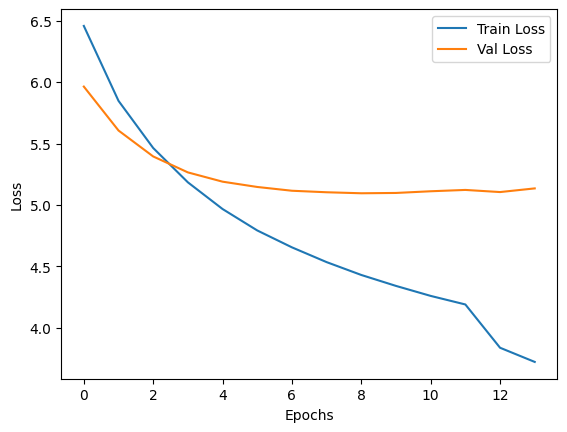

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
import pickle
torch.save(model.state_dict(), "translator_model_English_to_Hindi.pth")
pickle.dump(engH_vocab, open("engH_vocab.pkl", "wb"))
pickle.dump(hn_vocab, open("hn_vocab.pkl", "wb"))

In [17]:
def translate_sentence(model, sentence, engH_vocab, hn_vocab, max_len=10, device="cuda"):
    model.eval()
    tokens = word_tokenize(sentence.lower())
    encoded = [engH_vocab.get(word, 0) for word in tokens]
    padded = encoded + [0] * (max_len - len(encoded)) if len(encoded) < max_len else encoded[:max_len]
    input_tensor = torch.tensor([padded], dtype=torch.long).to(device)

    with torch.no_grad():
        output = model(input_tensor)
    
    predicted_tokens = output.argmax(2).squeeze().tolist()
    rev_hn_vocab = {idx: word for word, idx in hn_vocab.items()}
    translated_sentence = " ".join([rev_hn_vocab.get(idx, "") for idx in predicted_tokens])

    return translated_sentence

In [ ]:
# Example usage
loaded_model = LSTMTranslator(len(engH_vocab), 128, 512, len(hn_vocab)).to(device)
loaded_model.load_state_dict(torch.load("translator_model_English_to_Hindi.pth"))
loaded_model.eval()

example_sentence = "how are you"
predicted_translation = translate_sentence(loaded_model, 
                    example_sentence, engH_vocab, 
                    hn_vocab, device=device)
print(f"Translation: {predicted_translation}")

Translation: आप कैसे हो ? <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
